<a href="https://colab.research.google.com/github/ajaykgautam/PNamePid/blob/main/Valcano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import os
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
from math import sqrt
import shutil
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
import seaborn as sns
from matplotlib.cm import get_cmap

In [ ]:
def process_file_sliding_window(filename, window_size=100):
    with open(filename, 'r') as file:
        lines = file.readlines()

    start_index = None
    for i, line in enumerate(lines):
        if line.startswith('tilt_erupt'):
            start_index = i + 1
            break

    if start_index is not None:
        # Collect subsequent lines that contain the time and data values
        time_values = []
        data_values = []

        for line in lines[start_index:]:
            if ',' in line:
                if not time_values:
                    time_values = line.strip().split(',')
                else:
                    # Only process the first two lines after tilt_erupt
                    data_values = line.strip().split(',')
                    break

        # Print debug information for validation
        #print(f"Processing file: {filename}")

        if len(time_values) != len(data_values):
            print(f"Time and data value lengths do not match in file: {filename}")
            # Return empty DataFrame for consistency
            return pd.DataFrame()

        # Stop at the value "0"
        zero_index = time_values.index('0') if '0' in time_values else len(time_values)
        #includes the time 0 value and its corresponding data value.
        time_values = time_values[:zero_index + 1]
        data_values = data_values[:zero_index + 1]

        # Generate DataFrame with windows of window_size values
        df_list = []
        for start in range(len(time_values) - window_size + 1):
            end = start + window_size
            if end <= len(time_values):
                df = pd.DataFrame({
                    **{f'time_{i}': [time_values[start:end][i]] for i in range(window_size)},
                    **{f'intensity_{i}': [data_values[start:end][i]] for i in range(window_size)}
                })
                df_list.append(df)

        return pd.concat(df_list, ignore_index=True)

    print(f"No valid tilt_erupt data found in file: {filename}")
    return pd.DataFrame()

In [ ]:
def read_sensor_data_from_directory_sliding_window(directory_path, window_size=100):
    sensor_data = []
    for subdir, _, _ in os.walk(directory_path):
        for filename in glob.glob(os.path.join(subdir, "observation*.txt")):
            df = process_file_sliding_window(filename, window_size)
            if not df.empty:
                sensor_data.append(df)
    return sensor_data

In [ ]:
def write_to_csv(sensor_data, output_file):
    try:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(output_file), exist_ok=True)

        if sensor_data:
            # Concatenate all non-empty DataFrames
            combined_data = pd.concat(sensor_data, ignore_index=True)
            # Write combined data to CSV
            combined_data.to_csv(output_file, index=False)
            print(f"CSV file written successfully to {output_file}")
        else:
            print("No valid data to write to CSV.")
    except ValueError as e:
        print(f"Error in concatenating DataFrames: {e}")
    except Exception as e:
        print(f"An error occurred while writing to CSV: {e}")

In [ ]:
# Model Evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return mse, rmse, r2, y_pred

In [ ]:
def run_and_evaluate_models(data_file):
    df = pd.read_csv(data_file)

    if df.empty:
        print("The DataFrame is empty. No data available for regression.")
        return

    if 'intensity_0' not in df.columns:
        print("Error: Intensity columns not found in the DataFrame")
        return

    X = df.drop(columns=[col for col in df.columns if col.startswith('time') or col == 'intensity_99']).to_numpy()
    y = df['intensity_99'].astype(float).to_numpy()
    # Ensure we have more than one feature
    if X.shape[1] < 2:
        print("Error: The data does not have enough features for RFECV.")
        return

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Feature selection using RFECV (Recursive Feature Elimination with Cross-Validation)
    estimator = DecisionTreeRegressor(random_state=42)
    selector = RFECV(estimator, step=1, cv=5, scoring='neg_mean_squared_error')
    X_train = selector.fit_transform(X_train, y_train)
    X_test = selector.transform(X_test)

    print(f"Optimal number of features: {selector.n_features_}")

    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Support Vector Regression': SVR(),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'Neural Network': MLPRegressor(random_state=42),
        'AdaBoost': AdaBoostRegressor(random_state=42)
    }
    #Hyperparameter Tuning
    #param_grids dictionary specifies different hyperparameters for each model,
    #allowing GridSearchCV to find the best combination of parameters.

    param_grids = {
        'Linear Regression': {},
        #Depths of 3 and 5 are shallow trees, which can help prevent overfitting.
        #Depth of 10 is deeper, allowing for more complexity to capture patterns
        #in the data.
        'Decision Tree': {'max_depth': [3, 5, 10]},
        #n_estimators values are commonly used to balance model performance and
        #computational efficiency.  max_depth [None, 10, 20]
        #None allows trees to grow until all leaves are pure or contain less
        #than the minimum samples split.
        #Depths of 10 and 20 provide controlled complexity, preventing
        #overfitting while capturing enough details.
        'Random Forest': {'n_estimators': [50, 100], 'max_depth': [None, 10, 20]},
        #C is the regularization parameter; lower values encourage smoother
        #decision boundaries, preventing overfitting.
        #Higher values reduce regularization, allowing the model to fit the
        #training data more closely.
        #epsilon specifies the epsilon-tube within which no penalty is associated
        #with the training loss, these values help control the width of the tube,
        #affecting model flexibility.
        'Support Vector Regression': {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.2]},
        #n_estimators [50, 100]: number of boosting stages; higher values can
        #improve performance but increase computation time.
        #learning_rate [0.01, 0.1]: Smaller learning rates (0.01) provide more
        #robust and gradual learning, reducing the risk of overfitting.
        #Larger learning rates (0.1) speed up learning but can overfit if too high.
        'Gradient Boosting': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]},
        #hidden_layer_sizes [(50,), (50, 50)]: Single layer of 50 units and two
        #layers of 50 units each represent simple and moderately complex network
        #structures.
        #max_iter [100, 200]: maximum iterations for the optimization algorithm;
        #ensures convergence within reasonable time.
        #alpha [0.0001, 0.001]: regularization parameter to prevent overfitting
        #by penalizing large weights in the model.
        'Neural Network': {'hidden_layer_sizes': [(50,), (50, 50)], 'max_iter': [100, 200], 'alpha': [0.0001, 0.001]},
        #n_estimators [50, 100]: number of boosting stages; balances between
        #learning thoroughness and computation time.
        #learning_rate [0.01, 0.1]: controls the contribution of each classifier,
        #lower rates reduce the risk of overfitting, higher rates accelerate learning.
        'AdaBoost': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
    }

    results = {}
    #Cross-Validation
    #KFold cross-validation with 5 splits to ensure robust performance evaluation
    #during the GridSearchCV process.
    #The GridSearchCV with cross-validation finds the best model parameters by
    #splitting the training data into multiple folds.

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    #After training the models using GridSearchCV, the script evaluates each
    #model on the test set and calculates the performance metrics: MSE, RMSE, and R².

    for name, model in models.items():
        grid_search = GridSearchCV(model, param_grids[name], cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        mse, rmse, r2, y_pred = evaluate_model(best_model, X_test, y_test)
        results[name] = {
            'model': best_model,
            'mse': mse,
            'rmse': rmse,
            'r2': r2,
            'y_pred': y_pred
        }
        print(f"{name} - MSE: {mse}, RMSE: {rmse}, R-squared: {r2}")

    return results, X_test, y_test

In [ ]:
def plot_results(results, X_test, y_test):
    plt.figure(figsize=(18, 10))
    # Generate a color palette with unique colors
    colors = sns.color_palette("husl", len(results))
    for idx, (name, result) in enumerate(results.items()):
        plt.scatter(X_test, y_test, color='black', s=10, label='Actual values')
        plt.scatter(X_test, result['y_pred'], color=colors[idx], label=f'{name} Predictions')

        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'{name} - Actual vs Predicted Values')
        plt.legend()
        plt.show()

In [ ]:
def print_csv_file(output_file):
    try:
        # Concatenate all non-empty DataFrames
        combined_data = pd.concat(sensor_data, ignore_index=True)
        # Write combined data to CSV
        combined_data.to_csv(output_file, index=False)
        print(f"CSV file written successfully to {output_file}")
    except ValueError as e:
        print(f"Error in concatenating DataFrames: {e}")

In [ ]:
def extract_remaining_time(sensor_data):
    # Extract the last column as the target variable
    return sensor_data.iloc[:, -1].to_numpy()

In [ ]:
def extract_features_and_target(csv_file):
    try:
        # Load the CSV file into a DataFrame
        df = pd.read_csv(csv_file)

        # Ensure the DataFrame is not empty
        if df.empty:
            print("The CSV file is empty.")
            return None, None

        # Extract features (X) - all columns except the last one
        X = df.iloc[:, :-1].to_numpy()

        # Extract target variable (y) - the last column
        y = extract_remaining_time(df)

        return X, y
    except Exception as e:
        print(f"An error occurred while extracting features and target: {e}")
        return None, None

In [ ]:
def final_evaluation_on_unseen_data(results, unseen_data_file):
    df_unseen = pd.read_csv(unseen_data_file)

    if df_unseen.empty:
        print("The unseen data file is empty. Please provide data for final evaluation.")
        return

    if 'intensity_0' not in df_unseen.columns:
        print("Error: Intensity columns not found in the unseen data file")
        return

    # Dynamically determine the last intensity column
    last_intensity_column = df_unseen.columns[df_unseen.columns.str.startswith('intensity_')].max()

    X_unseen = df_unseen.drop(columns=[col for col in df_unseen.columns if col.startswith('time') or col == last_intensity_column]).to_numpy()
    y_unseen = df_unseen[last_intensity_column].astype(float).to_numpy()

    final_results = {}
    for name, result in results.items():
        model = result['model']
        y_pred = model.predict(X_unseen)

        mse = mean_squared_error(y_unseen, y_pred)
        rmse = sqrt(mse)
        r2 = r2_score(y_unseen, y_pred)

        final_results[name] = {
            'mse': mse,
            'rmse': rmse,
            'r2': r2,
            'y_pred': y_pred
        }

        print(f"{name} on Unseen Data - MSE: {mse}, RMSE: {rmse}, R-squared: {r2}")

    return final_results, X_unseen, y_unseen

In [ ]:
def plot_final_results(final_results, X_unseen, y_unseen):
    plt.figure(figsize=(12, 8))
    # Get the colormap
    cmap = get_cmap('tab10')
    # Generate distinct colors
    colors = [cmap(i) for i in range(len(final_results))]
    for i, (name, result) in enumerate(final_results.items()):
        plt.scatter(y_unseen, result['y_pred'], label=name, alpha=0.5, color=colors[i])
    plt.plot([y_unseen.min(), y_unseen.max()], [y_unseen.min(), y_unseen.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Model Predictions vs Actual on Unseen Data')
    plt.legend()
    plt.show()

In [ ]:
def create_unseen_data_file(unseen_data_file):
    if not os.path.exists(unseen_data_file):
        print(f"The unseen data file does not exist. add the unseen data to {unseen_data_file} for final evaluation.")
        data = {
            'time_0': [-20, -19, -18, -17, -16],
            'time_1': [-19, -18, -17, -16, -15],
            'intensity_0': [-9.65665230578541e-10, -1.04046681765392e-09, -5.09361999274875e-10, -8.21860740302696e-10, -5.24309264539405e-10],
            'intensity_1': [-1.04046681765392e-09, -5.09361999274875e-10, -8.21860740302696e-10, -5.24309264539405e-10, -1.11836634944131e-10],
        }
        df = pd.DataFrame(data)
        df.to_csv(unseen_data_file, index=False)
        print(f"Unseen data file created at {unseen_data_file}")
    else:
        print(f"Unseen data file exists at {unseen_data_file}")

In [ ]:
    from google.colab import drive
    # Unmount Google Drive if already mounted
    if os.path.isdir('/content/drive'):
        drive.flush_and_unmount()
    # Remove the mount directory if it exists and recreate it
    if os.path.exists('/content/drive'):
        shutil.rmtree('/content/drive')
    os.makedirs('/content/drive')

    # Mount Google Drive
    drive.mount('/content/drive')

Mounted at /content/drive


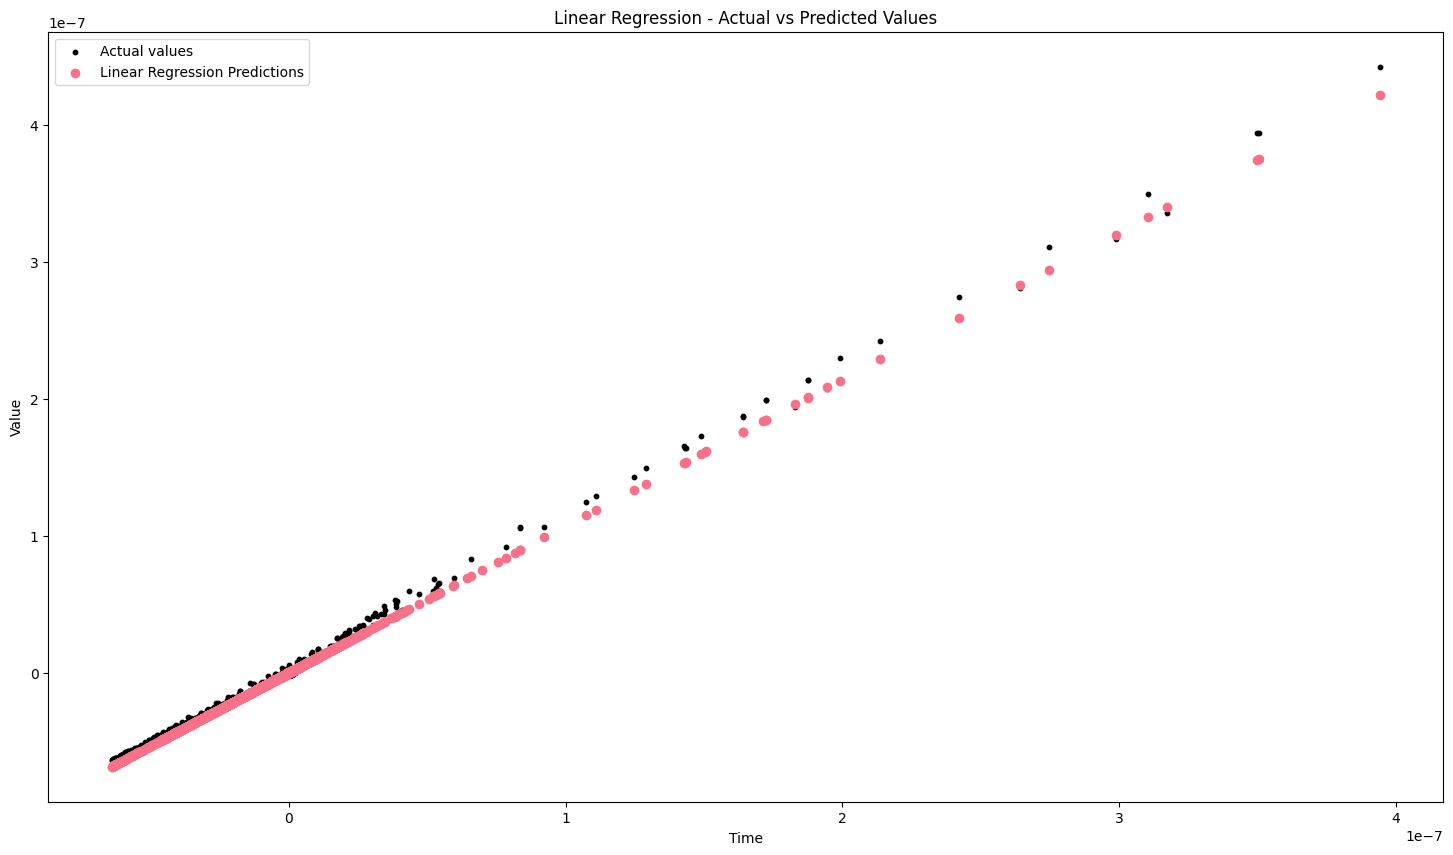

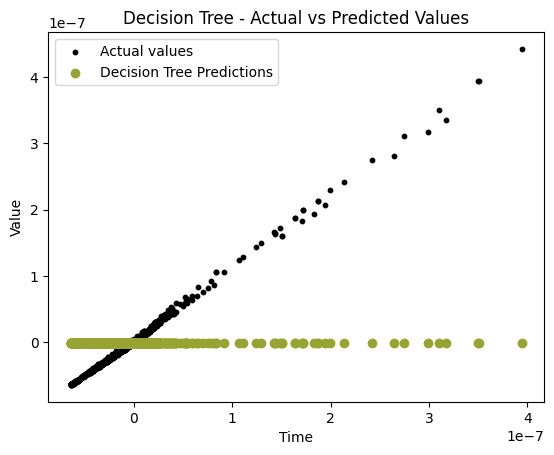

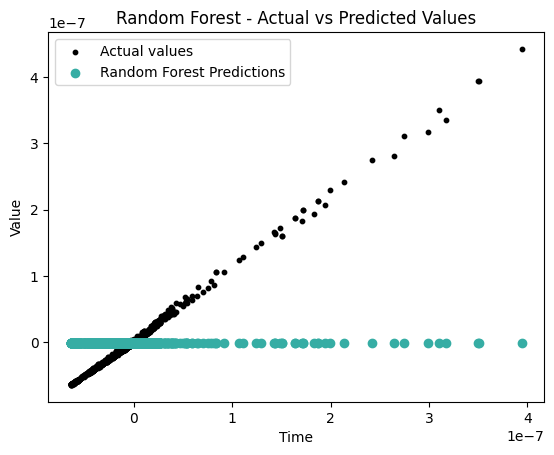

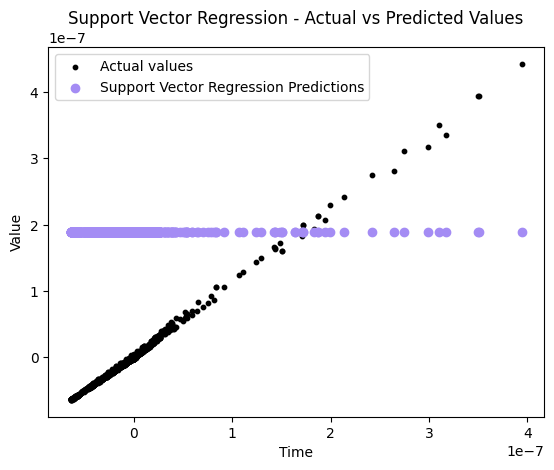

Unseen data file exists at /content/drive/MyDrive/unseen_data.csv
Linear Regression on Unseen Data - MSE: 1.2795295551775296e-19, RMSE: 3.577051236951366e-10, R-squared: -0.2912313854256723
Decision Tree on Unseen Data - MSE: 1.4933337679838187e-19, RMSE: 3.864367694699637e-10, R-squared: -0.5069909267309969
Random Forest on Unseen Data - MSE: 1.4622476967317129e-19, RMSE: 3.8239347493540116e-10, R-squared: -0.47562056042106926
Support Vector Regression on Unseen Data - MSE: 3.6033180054887825e-14, RMSE: 1.898240765943241e-07, R-squared: -363626.1848141097


<ipython-input-107-696417cff041>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')


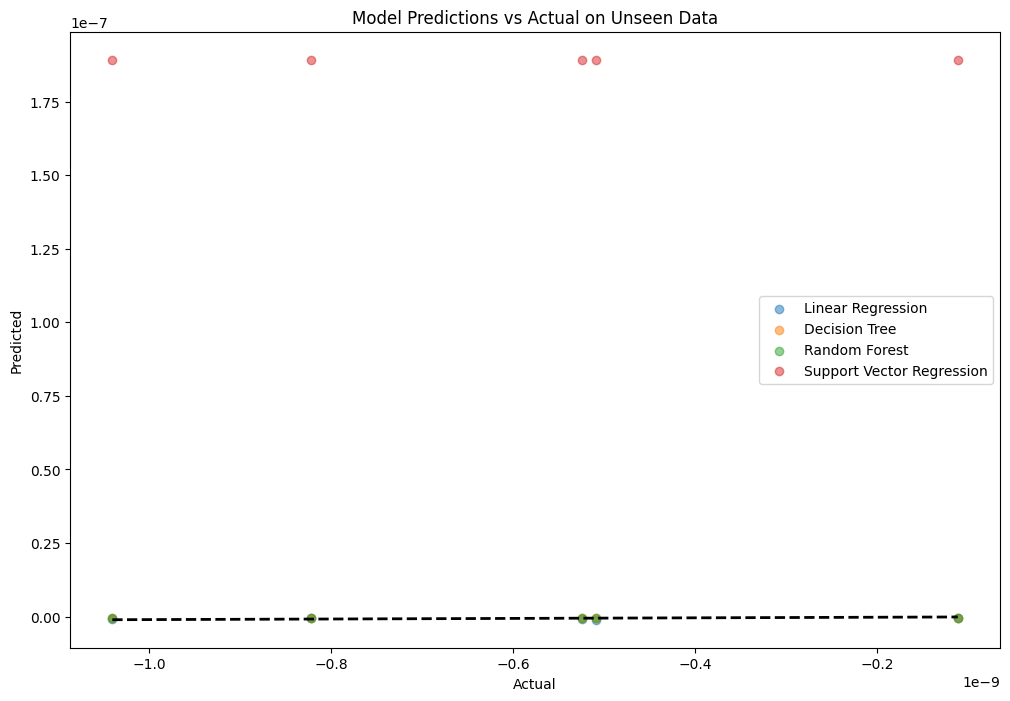

In [ ]:
# Example usage
if __name__ == "__main__":
    from sklearn.model_selection import train_test_split
    directory_path = "/content/drive/MyDrive/Volcano_Dataset"
    output_file = "/content/drive/MyDrive/sensor_data.csv"
    unseen_data_file = "/content/drive/MyDrive/unseen_data.csv"

    sensor_data = read_sensor_data_from_directory_sliding_window(directory_path, window_size=100)
    write_to_csv(sensor_data, output_file)
    #print_csv_file(output_file)

    results, X_test, y_test = run_and_evaluate_models(output_file)

    plot_results(results, X_test, y_test)

    create_unseen_data_file(unseen_data_file)
    final_results, X_unseen, y_unseen = final_evaluation_on_unseen_data(results, unseen_data_file)

    plot_final_results(final_results, X_unseen, y_unseen)
